In [55]:
import numpy as np
import cft
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [32]:
plt.rcParams['figure.figsize'] = (14, 8)

def plot_image(box, data, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.imshow(data, extent=[0, box.L, 0, box.L], interpolation='nearest')
    plt.show()

# Adhesion

First we need initial conditions. These are generated using the `cft` module, which can also compute ICs using constraints. But we won't use that here. Here we only do 2D computations; however, the method is completely generic. So 3D (besides performance issues) should not be problem.

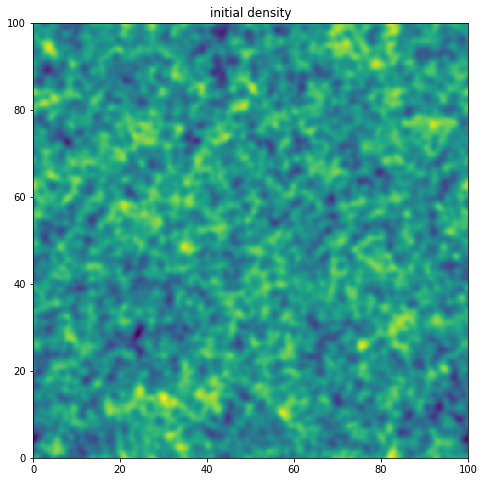

In [65]:
box = cft.Box(dim=2, N=512, L=100.)
P = cft.Power_law(n=-1) * cft.Scale(box, 1.0)
delta_0 = cft.garfield(B=box, P=P, seed=42)
delta_0 /= delta_0.std()
# plot the density
plot_image(box, delta_0, "initial density")

### Computing the potential

Next, to compute the potential, we use Fourier integration of Poissons equation:
$$-k^2 \hat{\Phi}(k) = \hat{\delta}_0(k)$$

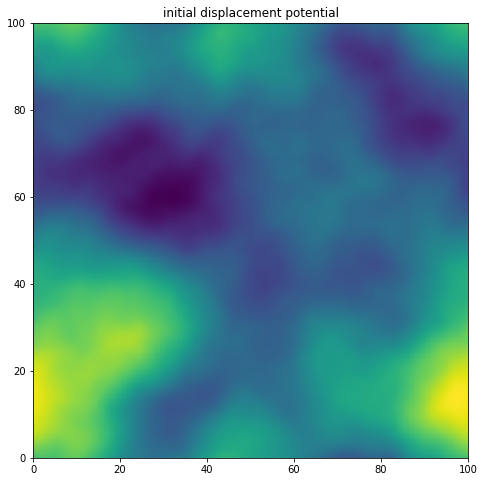

In [66]:
pot_0 = np.fft.ifftn(np.fft.fftn(delta_0) * cft.Potential()(box.K)).real
plot_image(box, pot_0, "initial displacement potential")

### Create points for convex hull computation
Now, to compute the adhesion approximation, we need to lift the grid points to a parabola, adding the displacement potential as a weight.
$$q_z = q^2 - 2 t \Phi(q)$$

In [76]:
def lagrangian_vertices(box, pot, t):
    q = np.indices(box.shape) * box.L/box.N
    z = np.sum(q**2, axis=0) - 2 * t * pot
    return np.concatenate([q, np.expand_dims(z, 0)], 0).reshape(box.dim+1, -1).T

In [77]:
pts = lagrangian_vertices(box, pot_0, 1.0)

### Compute the convex hull

In [78]:
ch = ConvexHull(pts)

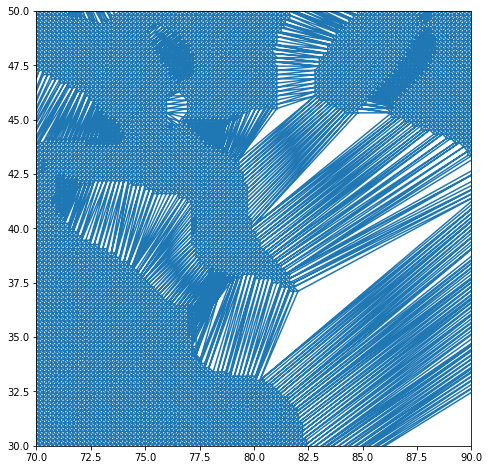

In [81]:
def plot_regular_triangulation(ch, xlim=None, ylim=None):
    x = ch.points[:,0]
    y = ch.points[:,1]
    t = ch.simplices


    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.triplot(x, y, t)
    plt.show()

plot_regular_triangulation(ch, [70, 90], [30, 50])

In [97]:
def calc_normals(ch):
    parab = np.zeros_like(ch.points)
    parab[:,2] = (ch.points[:,:2]**2).sum(axis=1)
    phi_pts = parab/2 - ch.points

    def normalise(vec):
        sign = vec[2]/abs(vec[2])
        return vec/np.sqrt((vec**2).sum()) * sign
    
    def flat(p):
        return p[:2]
    
    def normal(s):
        if len(s) != 3:
            return False
        
        a, b, c = ch.points[s]
        p, q, r = phi_pts[s]
        
        n = np.cross(a - b, c - b)
        
        pn = np.cross(p - q, r - q)
        g = np.array([-pn[2]*pn[0], -pn[2]*pn[1], pn[0]**2 + pn[1]**2]) \
            / (pn[0]**2 + pn[1]**2)
            
        A = np.cross(flat(a) - flat(b), flat(c) - flat(b))/2
        p = (a + b + c)/3
        
        return p, A, -n[:2]/n[2], g
     
    return [normal(s) for s in ch.simplices if len(s) == 3]

In [98]:
V = calc_normals(ch)

/home/johannes/.local/share/workon/adhesion/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/johannes/.local/share/workon/adhesion/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [101]:
x = np.array([v[2] for v in V])

In [102]:
x

array([[  99.78613463,   99.80813567],
       [  99.78612362,   99.80812466],
       [   2.4930995 ,  103.3366996 ],
       ..., 
       [         -inf,           nan],
       [          inf,           nan],
       [          inf,           nan]])

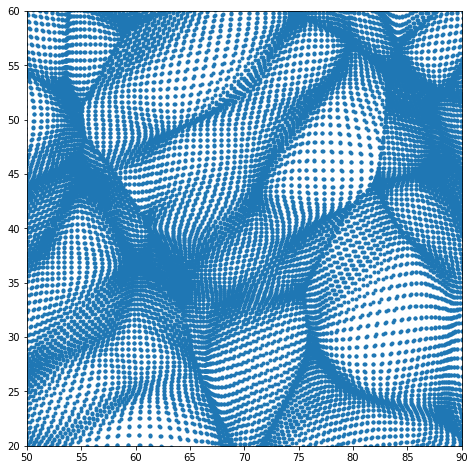

In [105]:
def plot_voronoi_points(X, xlim=None, ylim=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.plot(X[:,0], X[:,1], '.')
    plt.show()

plot_voronoi_points(x, [50, 90], [20, 60])